# Feature exploration  

Contains two major tasks:  

- calculate the correlation between the input features and remove high VIF features
- visualize 2D histogram plots between each input feature and the target variable to be predicted.

In [1]:
import os
import sys
nb_dir = "./include_files"
if nb_dir not in sys.path:
    sys.path.append(nb_dir)


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
%matplotlib inline

from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.style as style
style.use('fivethirtyeight')

# plt.style.use("./include_files/marius.mplstyle")
# fontSize = 15
# lineWidth = 1.5

colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', 
          u'#7f7f7f', u'#bcbd22', u'#17becf']

## Read the input data

In [2]:
data = np.load( "data/NN_feature_data_N=5e4.npz" )

for key in data.files:
    code = key + ' = data["' + key + '"]'
    print(code)
    exec( code )

print( "\nSize of the input feature vector: ", data_input.shape, len(name_input) )
print( "Size of the output vector: ", data_output.shape )

num_features = data_input.shape[1]

data_input = data["data_input"]
data_output = data["data_output"]
name_input = data["name_input"]
name_output = data["name_output"]

Size of the input feature vector:  (50000, 10) 10
Size of the output vector:  (50000, 1)


## Define the bins for the features that contain a discrete number of values

In [3]:
num_X_bins = np.repeat( 50, num_features )
for i in range( 1, 6 ):
    num_X_bins[i] = data_input[:,i].max() + 1
    
num_Y_bins = 50

print( "Number of X-bins for each feature: " )
for i in range(num_features):
    print( "\t", name_input[i], "\t", num_X_bins[i] )
print( "Number of Y_bins: ", num_Y_bins )

Number of X-bins for each feature: 
	 M_star 	 50
	 N_sat 1.e6 	 32
	 N_sat 1.e7 	 24
	 N_sat 1.e8 	 12
	 N_sat 1.e9 	 6
	 N_sat 1.e10 	 3
	 vel. tan. 	 50
	 vel. radial 	 50
	 mean L 	 50
	 mean d 	 50
Number of Y_bins:  50


## Rescale the input and output [min,max] to the range [0,1]  

Use the **min_max_scaler** from sklearn. Use:
- **fit_transform(X)** to calculate the min & max values
- **transform(X)** to apply a transformation for which you already calculated the min & max values

In [4]:
from sklearn import preprocessing

input_min_max_scaler = preprocessing.MinMaxScaler()
x_data = input_min_max_scaler.fit_transform( data_input )

output_min_max_scaler = preprocessing.MinMaxScaler()
y_data = input_min_max_scaler.fit_transform( data_output )

## 1. Calculate the correlation coefficients and check for multicollinearity  

For this, we will use the Pearson correlation coefficient and consider as high multicollinearity features as the ones that have VIF>5.

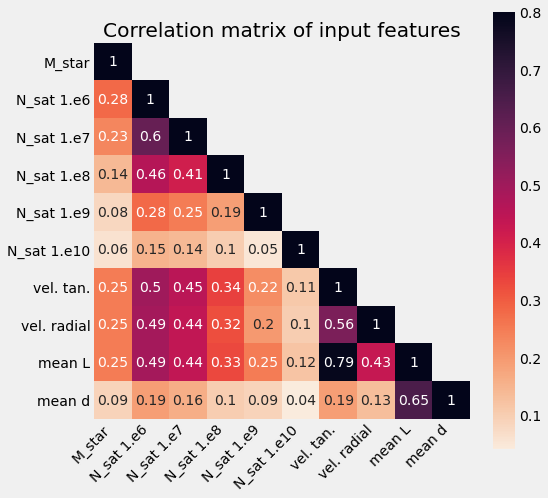

In [5]:
corr = np.corrcoef( x_data, rowvar=False)

corr2 = corr.round(2)
mask = np.zeros_like( corr2 )
mask[ np.triu_indices_from(mask,k=1) ] = True

plt.figure( figsize=(7.5,7.5) )
plt.title( "Correlation matrix of input features" )
ax = sns.heatmap( corr2, mask=mask, square=True, annot=True, vmax=0.8, cmap="rocket_r" )

ax.set_yticklabels( name_input, rotation=0, horizontalalignment='right' )
ax.set_xticklabels( ax.get_yticklabels(), rotation=45, horizontalalignment='right' )
plt.show()

We find a couple of features are strongly correlate, for example 'mean L' and 'vel. tan.' have a 0.79 correlation coefficient.

## Calculating the Variance Inflation Factor (VIF) and removing features with high VIF  

Remove a feature one at a time starting with the feature with the highest VIF.  

Only remove features with VIF > 5. -- these are the high multicollinearity or highly correlated.  

Need to remove one feature at a time since removing one features affects the VIF value of all the features.

In [6]:
sel = np.ones( corr.shape[0], bool )  # selection matrix used to remove features with high VIF
VIF = np.zeros( corr.shape[0], float  )

while True:
    VIF[sel] = np.linalg.inv(corr[sel][:,sel]).diagonal()
    VIF[~sel] = 0.
    
    print( "\nLoop  << %i >>\n" % (sel.shape[0]-sel.sum()) )
    print( "Feature  \tVIF" )
    [ print("{:<12}".format(name_input[i]), "\t%.1f" % VIF[i]) for i in np.arange(num_features)[sel] ]
    [ print("{:<12}".format(name_input[i]), "\tREMOVED") for i in np.arange(num_features)[~sel] ]
    
    if VIF.max() > 5.:
        sel[ VIF.argmax() ] = False
    else:
        break


Loop  << 0 >>

Feature  	VIF
M_star       	1.1
N_sat 1.e6   	2.0
N_sat 1.e7   	1.7
N_sat 1.e8   	1.3
N_sat 1.e9   	1.1
N_sat 1.e10  	1.0
vel. tan.    	6.1
vel. radial  	1.7
mean L       	9.5
mean d       	3.5

Loop  << 1 >>

Feature  	VIF
M_star       	1.1
N_sat 1.e6   	2.0
N_sat 1.e7   	1.7
N_sat 1.e8   	1.3
N_sat 1.e9   	1.1
N_sat 1.e10  	1.0
vel. tan.    	1.7
vel. radial  	1.6
mean d       	1.1
mean L       	REMOVED


Initially two features had VIF>5: 'vel. tan.' and 'mean L'. 

In a first step, we proceeded to remove the feature with the highest VIF, and the result is 9 features each with small VIF. Thus, there is no need to remove any more features.  

In our analysis, we will consider all features (even the high multicollinearity ones) and only remove the ones with high VIF when interpreting the feature importance.

## Understand the relation between each input feature and the output  

For this, we calculate the **Pearson and Spearman rank correlation coefficients** between each input feature and the output.  

Also, we use a 1D kNN approach to calculate what is the mean-squared-error (MSE) with which each feature individually can predict the output.

In [7]:
# The Pearson and Spearman correlation coefficients
from scipy.stats import pearsonr, spearmanr
PCC = [ pearsonr(x_data[:,i],y_data[:,0])[0] for i in range(num_features) ]
PCC = np.array(PCC).round(2)
SCC = [ spearmanr(x_data[:,i],y_data[:,0])[0] for i in range(num_features) ]
SCC = np.array(SCC).round(2)

print( "Feature      PCC     SCC" )
discard = [ print("{:<12}".format(name_input[i]),"%.2f"%PCC[i],"  %.2f"%SCC[i]) for i in range(num_features) ]

Feature      PCC     SCC
M_star       0.43   0.41
N_sat 1.e6   0.73   0.66
N_sat 1.e7   0.66   0.59
N_sat 1.e8   0.52   0.45
N_sat 1.e9   0.36   0.32
N_sat 1.e10  0.19   0.16
vel. tan.    0.55   0.64
vel. radial  0.54   0.60
mean L       0.54   0.59
mean d       0.18   0.19


Most feature have high Pearson and Spearman correlation coefficients with the output indicating that they potentially contain useful information for predicting the output variable.

### Use a 1D kNN to calculate how well each feature individually can predict the output

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# construct a k-list to find the optimal k-value for each feature
k_list = 10 * np.arange( 1, 21 )

# use only half of the data for training
N_train = int(x_data.shape[0] / 2)

# optimal k-value defined in terms of MSE
# construct an array to keep track of all the MSE values
MSE_array = np.zeros( (num_features,k_list.shape[0],2), float )

# to understand the MSE, we need to compare with the MSE value for a random prediction
# for this, we will shuffle the true y_test and calculate the MSE using these shuffled values
shuffled_indices = np.arange(x_data.shape[0]-N_train, dtype=np.int32)
np.random.shuffle( shuffled_indices )

# very small random values to be added to the feature 
# to better deal with features that take integer values on a small range
randoms = np.random.normal( loc=0., scale=1.e-5, size=x_data[:,i].shape[0] ).reshape(-1,1)

for i in range(num_features):
    print( "Calculating MSE for feature %i - '%s' ... " % (i+1,name_input[i]) )
    
    # add a small random noise 
    feature = x_data[:,i].reshape(-1,1) + randoms
    
    for j,k in zip(np.arange(len(k_list)),k_list):
        print( k, end=" " )
        knn = KNeighborsRegressor(k)
        knn.fit( feature[:N_train], y_data[:N_train,0] )
        
        # calculate the MSE for the test set
        prediction = knn.predict(feature[N_train:])
        MSE_array[i,j,0] = mean_squared_error( prediction, y_data[N_train:,0] )
        
        # calculate the MSE for random matching, that is by shufling the y_true values
        MSE_array[i,j,1] = mean_squared_error( prediction, y_data[N_train:,0][shuffled_indices] )
    print()

# find the minimum MSE for each feature
min_index = MSE_array.argmin(axis=1)[:,0]
MSE_test = np.array([ MSE_array[i,min_index[i]] for i in range(num_features)])

# print the results
print( "\nFeature      MSE     percentage of random" )
discard = [ print("{:<12}".format(name_input[i]),"%.4f"%MSE_test[i,0], \
                  "  %.0f %%"%(MSE_test[i,0]*100./MSE_test[i,1]),) \
           for i in range(num_features) ]

Calculating MSE for feature 1 - 'M_star' ... 
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 
Calculating MSE for feature 2 - 'N_sat 1.e6' ... 
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 
Calculating MSE for feature 3 - 'N_sat 1.e7' ... 
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 
Calculating MSE for feature 4 - 'N_sat 1.e8' ... 
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 
Calculating MSE for feature 5 - 'N_sat 1.e9' ... 
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 
Calculating MSE for feature 6 - 'N_sat 1.e10' ... 
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 
Calculating MSE for feature 7 - 'vel. tan.' ... 
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 
Calculating MSE for feature 8 - 'vel. radial' ... 
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 
Calculating MSE for feature

## 2. Visualize 2D plots of various features vs. the output values  

This is used to get better insights into the connection between input features and the output.  

### Start by defining the plotting function

In [9]:
def running_percentiles(X, Y, bins):
    """Calculates running percentiles."""
    x_bins = np.linspace( X.min(), X.max(), num=bins+1 )
    x_vals = 0.5 * (x_bins[1:]+x_bins[:-1])
    percentiles = np.zeros( (bins,3), float )  # stores the percentiles for each bin
    count = np.zeros( bins, int )  # stores the number of points inside the bin
    for i in range(bins):
        # select all X values in the bin
        sel = (X>=x_bins[i]) * (X<x_bins[i+1])
        # calculate the y-percentiles for those entries inside the x-bin
        count[i] = sel.sum()
        if count[i] > 1:
            percentiles[i] = np.percentile( Y[sel], q=[50,16,84] )
    return count, percentiles, x_vals


def plot_2D_histogram( X, Y, i_feature, name_X, name_Y, bins, vrange=(0,100), \
                      percentiles=False, PCC=None, SCC=None, MSE=None, saveFile=None ):
    """Plots a 2D histogram of output versus selected feature."""
    print( "\nPloting 'output'='%s' vs. 'input feature %i'='%s'." % \
          (name_Y, i_feature, name_X)  )
    fig1 = plt.figure( figsize=(1*7.5,1*6.5) )
    gs = gridspec.GridSpec( 1, 1 )

    ax1 = plt.subplot( gs[0] )
    plt.title( "'output' vs. 'input feature %i'" % (i_feature+1), \
             loc='center', y=1.3 )
    plt.xlabel( r"Feature %i" % (i_feature+1) + ' - ' + name_X )
    plt.ylabel( r"Target output" ) # = %" % name_Y )
    
    # plot the histogram
    # d = plt.hexbin( X, Y, gridsize=bins, vmin=vrange[0], vmax=vrange[1], cmap='GnBu', alpha=1 )
    d = plt.hist2d( X, Y, bins=bins, vmin=vrange[0], vmax=vrange[1], cmap='GnBu', alpha=1 )
    plt.colorbar( location='top', label="Number of entries", aspect=20 )
    
    # plot running percentiles is requested so
    if percentiles:
        count, percentiles, x_vals = running_percentiles(X, Y, bins[0])
        sel = count > 20 # plot only bins with sufficient points to return robust results
        plt.plot( x_vals[sel], percentiles[sel][:,0], '-', c=colors[1] )
        plt.plot( x_vals[sel], percentiles[sel][:,1], ':', c=colors[1] )
        plt.plot( x_vals[sel], percentiles[sel][:,2], ':', c=colors[1] )
    
    # output the correlation coefficients
    if PCC: plt.text( 0.01, 0.95, "PCC = %.2f" % PCC )
    if SCC: plt.text( 0.01, 0.89, "SCC = %.2f" % SCC )
    if MSE is not None: plt.text( 0.01, 0.83, "MSE = %.4f (%.0f%%)" % (MSE[0], MSE[0]*100./MSE[1]) )
    
    # saved the figure is requsted so
    if saveFile:
        print( "Saving the plot to file '%s' ..." % saveFile )
        pp = PdfPages( saveFile )
        pp.savefig( fig1, bbox_inches='tight' )
        pp.close()
    plt.show()

### Show the relation for a few features  

The values shown on the plot are as follows:  
- **background colour** = number of entries in each bin. See colour scale on the top of the plot.
- **solid line** = median y-value for a given x bin (shown only if number of points inside the x-bin is large enough).
- **dotted lines** = the 16 and 84 percentiles of the y-distribution for each x-bin.
- **PCC** = text in upper-left corner giving the **Pearson correlation coefficient**.
- **SCC** = text in upper-left corner giving the **Spearman correlation coefficient**.
- **MSE** = text in upper-left corner giving the **mean squared error**. The value inside the brackets gives what percentage this is compared to the MSE for a random prediction. The lower the value inside the brackets the more information about the output this feature contains. 


Ploting 'output'='M_halo' vs. 'input feature 0'='M_star'.
Saving the plot to file 'figures/2D_hist_feature_0=M_star_vs_output.pdf' ...


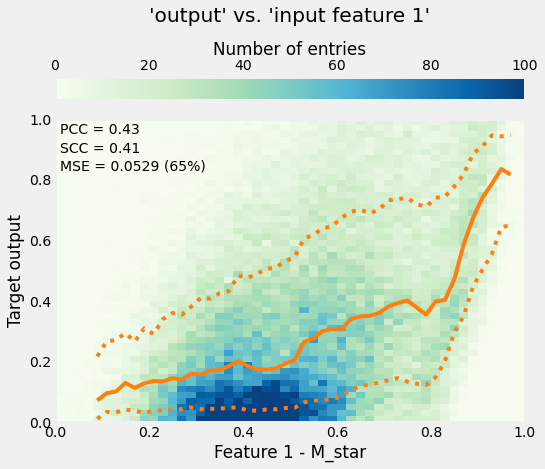


Ploting 'output'='M_halo' vs. 'input feature 1'='N_sat 1.e6'.
Saving the plot to file 'figures/2D_hist_feature_1=N_sat 1.e6_vs_output.pdf' ...


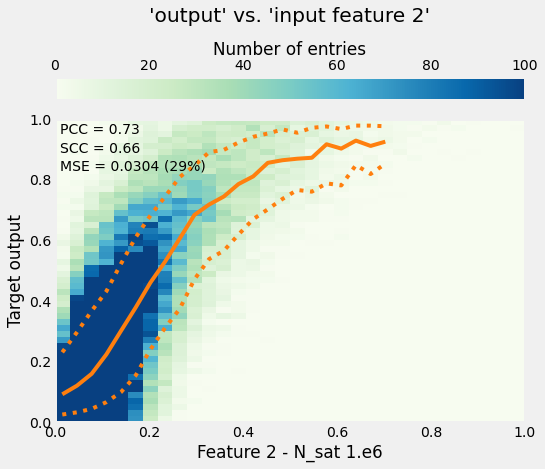


Ploting 'output'='M_halo' vs. 'input feature 6'='vel. tan.'.
Saving the plot to file 'figures/2D_hist_feature_6=vel. tan._vs_output.pdf' ...


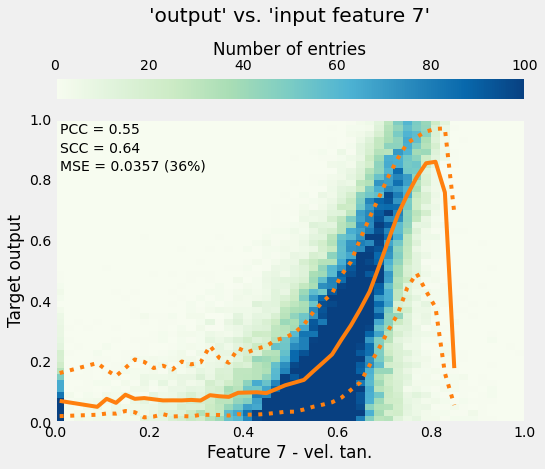


Ploting 'output'='M_halo' vs. 'input feature 7'='vel. radial'.
Saving the plot to file 'figures/2D_hist_feature_7=vel. radial_vs_output.pdf' ...


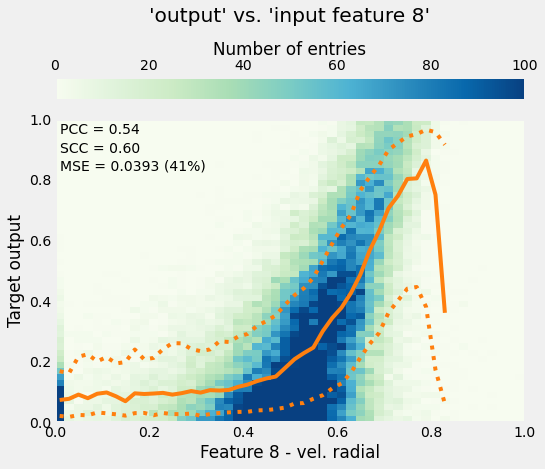


Ploting 'output'='M_halo' vs. 'input feature 8'='mean L'.
Saving the plot to file 'figures/2D_hist_feature_8=mean L_vs_output.pdf' ...


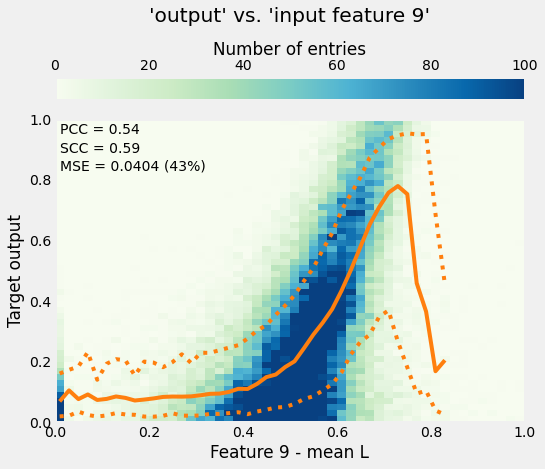


Ploting 'output'='M_halo' vs. 'input feature 9'='mean d'.
Saving the plot to file 'figures/2D_hist_feature_9=mean d_vs_output.pdf' ...


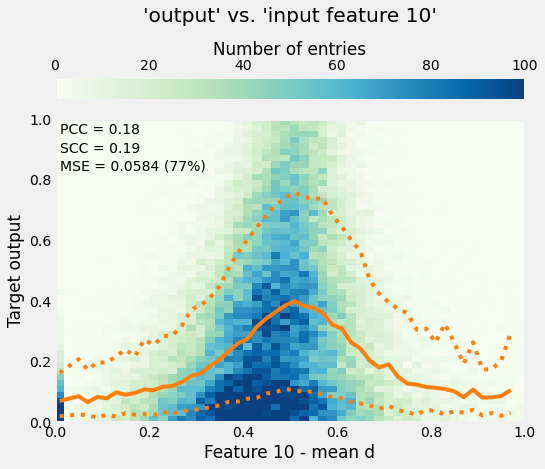

In [10]:
list_i_feature = [0 , 1, 6, 7, 8, 9 ]
list_save_files= [ "figures/2D_hist_feature_%i=%s_vs_output.pdf" % (list_i_feature[i], name_input[list_i_feature[i]]) \
                 for i in range(len(list_i_feature)) ]
# print( list_save_files )

for i, i_feature in zip( range(len(list_i_feature)), list_i_feature ):
    plot_2D_histogram( x_data[:,i_feature], y_data[:,0], i_feature, name_input[i_feature], name_output[0], 
                      bins=(num_X_bins[i_feature],num_Y_bins), vrange=(0,100), \
                      percentiles=True, \
                      PCC=PCC[i_feature], SCC=SCC[i_feature], MSE=MSE_test[i_feature], \
                      saveFile=list_save_files[i] \
                     )


Ploting 'output'='M_halo' vs. 'input feature 0'='M_star'.
Saving the plot to file 'figures/2D_hist_feature_0=M_star_vs_output_no_percentile.pdf' ...


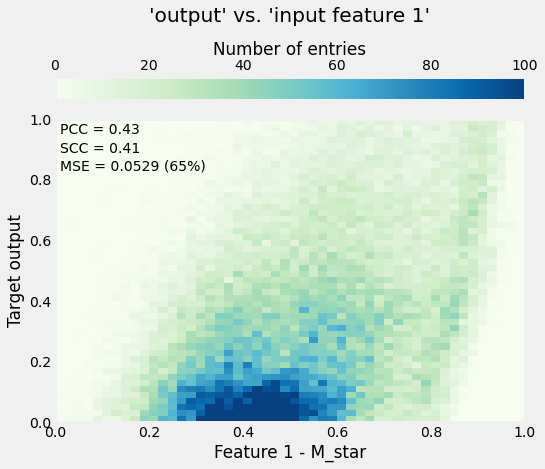

In [11]:
list_i_feature = [0] # , 1, 6, 7, 8, 9 ]
list_save_files= [ "figures/2D_hist_feature_%i=%s_vs_output_no_percentile.pdf" % (list_i_feature[i], name_input[list_i_feature[i]]) \
                 for i in range(len(list_i_feature)) ]
# print( list_save_files )

for i, i_feature in zip( range(len(list_i_feature)), list_i_feature ):
    plot_2D_histogram( x_data[:,i_feature], y_data[:,0], i_feature, name_input[i_feature], name_output[0], 
                      bins=(num_X_bins[i_feature],num_Y_bins), vrange=(0,100), \
                      percentiles=False, \
                      PCC=PCC[i_feature], SCC=SCC[i_feature], MSE=MSE_test[i_feature], \
                      saveFile=list_save_files[i] \
                     )